# 1. Introduction

GPT stands for "Generative Pre-trained Transformer." It is a type of artificial intelligence language model developed by OpenAI. The GPT model is built upon a deep learning architecture called the **Transformer**, which was introduced in the paper "[Attention is All You Need](https://arxiv.org/abs/1706.03762)" by Vaswani et al. in 2017.

The primary characteristic of GPT is its ability to generate human-like text by predicting the next word in a sequence based on the context of the previous words. The model is exposed to vast amounts of text, allowing it to learn patterns and relationships within the language. This way, GPT becomes familiar with various grammar structures, semantics, and factual information from the training data.

The model can be fine-tuned on specific tasks, like text generation, translation, summarization, question-answering, and more. This makes GPT a versatile language model that can be adapted to various natural language processing tasks.

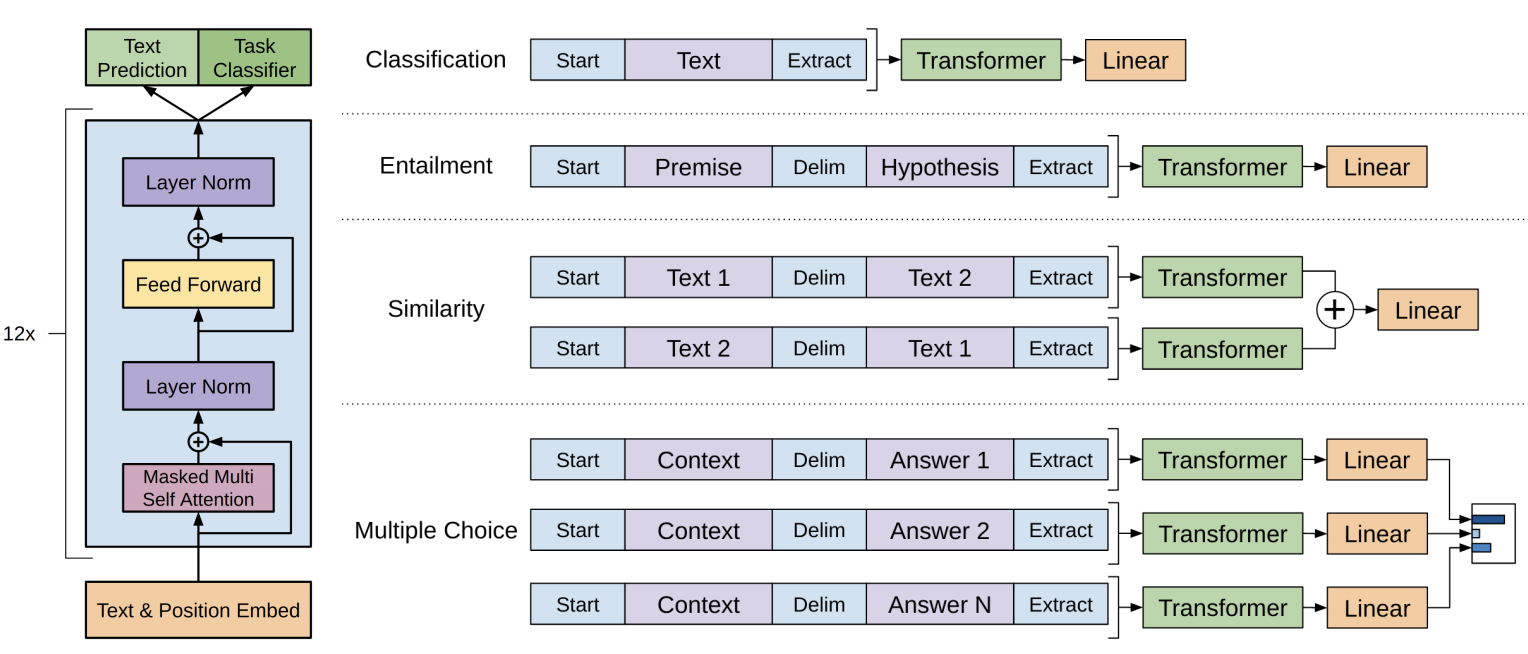

# 2. Install and Import Dependencies

In [ ]:
!git clone https://github.com/karpathy/nanoGPT
%cd nanoGPT

Cloning into 'nanoGPT'...
remote: Enumerating objects: 649, done.
remote: Total 649 (delta 0), reused 0 (delta 0), pack-reused 649
Receiving objects: 100% (649/649), 936.46 KiB | 5.96 MiB/s, done.
Resolving deltas: 100% (371/371), done.
/content/nanoGPT


In [ ]:
!pip install torch numpy transformers datasets tiktoken wandb tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 73.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires openai, which is not installed.


# 3. Download Shakespeare data

Let's train a character-level GPT on the works of Shakespeare. First, we download it as a single (1MB) file and turn it from raw text into one large stream of integers:

In [ ]:
!python3 data/shakespeare_char/prepare.py


length of dataset in characters: 1,115,394
all the unique characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab size: 65
train has 1,003,854 tokens
val has 111,540 tokens


# 4. Train on the Shakespeare data

Now let's train our model.

In [ ]:
import torch
using_GPU = torch.cuda.is_available()

In [ ]:
if using_GPU:
  !python3 train.py config/train_shakespeare_char.py

Overriding config with config/train_shakespeare_char.py:
# train a miniature character-level shakespeare model
# good for debugging and playing on macbooks and such

out_dir = 'out-shakespeare-char'
eval_interval = 250 # keep frequent because we'll overfit
eval_iters = 200
log_interval = 10 # don't print too too often

# we expect to overfit on this small dataset, so only save when val improves
always_save_checkpoint = False

wandb_log = False # override via command line if you like
wandb_project = 'shakespeare-char'
wandb_run_name = 'mini-gpt'

dataset = 'shakespeare_char'
gradient_accumulation_steps = 1
batch_size = 64
block_size = 256 # context of up to 256 previous characters

# baby GPT model :)
n_layer = 6
n_head = 6
n_embd = 384
dropout = 0.2

learning_rate = 1e-3 # with baby networks can afford to go a bit higher
max_iters = 5000
lr_decay_iters = 5000 # make equal to max_iters usually
min_lr = 1e-4 # learning_rate / 10 usually
beta2 = 0.99 # make a bit bigger because number of 

In [ ]:
if not using_GPU:
  !python train.py config/train_shakespeare_char.py --device=cpu --compile=False --eval_iters=20 --log_interval=1 --block_size=64 --batch_size=12 --n_layer=4 --n_head=4 --n_embd=128 --max_iters=2000 --lr_decay_iters=2000 --dropout=0.0

# 5. Test our Shakespearian Model

Let's see what our model produces.

In [ ]:
if using_GPU:
  !python sample.py --out_dir=out-shakespeare-char


Overriding: out_dir = out-shakespeare-char
Traceback (most recent call last):
  File "/content/nanoGPT/sample.py", line 38, in <module>
    checkpoint = torch.load(ckpt_path, map_location=device)
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 986, in load
    with _open_file_like(f, 'rb') as opened_file:
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 435, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 416, in __init__
    super().__init__(open(name, mode))
FileNotFoundError: [Errno 2] No such file or directory: 'out-shakespeare-char/ckpt.pt'


In [ ]:
if not using_GPU:
  !python sample.py --out_dir=out-shakespeare-char --device=cpu

# 6. Generate our own dataset from Wikipedia

Now, let's generate our own dataset and train a new model to this custom data. We'll look at many [Wikipedia](https://www.wikipedia.org/) pages.

First, install the `httpx` Python module and import some useful libraries/modules.

In [ ]:
!pip3 install httpx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.9 MB/s eta 0:00:00


In [ ]:
import httpx
import json
import re
import os
import tiktoken
import numpy as np
import random
from urllib.parse import urlencode

Next, let's make a directory for the data. This is just like `shakespeare_char`.

In [ ]:
!mkdir data/wikipediatext

Now, let's work on creating a file `input.json` that has the text from a bunch of Wikipedia articles.

In the following cell, add a bunch of Wikipedia articles for your model to be trained on. A few have been given as examples, but you may delete them if you choose to.

Note: we're not finetuning an already really great model with specific information. The model is being trained from scratch; the Wikipedia pages you give it is all it knows about language.

In [ ]:
articles = [
    "Python_(programming_language)",
    "Artificial_intelligence",
    "Machine_learning",
    # Add more Wikipedia article titles here.
]

Now, compile all of the information from the Wikipedia articles you gave it.

In [ ]:
tag_re = re.compile('<.*?>')

base_url = "https://en.wikipedia.org/w/api.php?"
params = {
    "action": "query",
    "format": "json",
    "prop": "extracts",
    "explaintext": "true",
    "titles": "",
}

fp = open("data/wikipediatext/input.json", "w")
for article in articles:
    params["titles"] = article
    url = base_url + urlencode(params)
    while url:
        data = httpx.get(url).json()
        pages = data["query"]["pages"]
        for page_id, page_data in pages.items():
            title = page_data["title"]
            content = page_data.get("extract", "")
            cleaned_content = tag_re.sub('', content)
            fp.write(json.dumps([title, cleaned_content]) + "\n")
        if "continue" in data:
            url = base_url + urlencode(data["continue"])
        else:
            url = None
fp.close()

Next, we'll create a train and validation set.

In [ ]:
input_file_path = 'data/wikipediatext/input.json'

entries = []
with open(input_file_path, 'r') as f:
    for line in f:
        if line.strip():
            entries.append(json.loads(line))

# Shuffle entries
random.shuffle(entries)

n = len(entries)
train_entries = entries[:int(n*0.9)]
val_entries = entries[int(n*0.9):]

# Turn those into strings
train_data = " ".join(
    "{} {}".format(*entry) for entry in train_entries
)
val_data = " ".join(
    "{} {}".format(*entry) for entry in val_entries
)

# encode with tiktoken gpt2 bpe
enc = tiktoken.get_encoding("gpt2")
train_ids = enc.encode_ordinary(train_data)
val_ids = enc.encode_ordinary(val_data)
print(f"train has {len(train_ids):,} tokens")
print(f"val has {len(val_ids):,} tokens")

# export to bin files
train_ids = np.array(train_ids, dtype=np.uint16)
val_ids = np.array(val_ids, dtype=np.uint16)
train_ids.tofile('data/wikipediatext/train.bin')
val_ids.tofile('data/wikipediatext/val.bin')

train has 22,469 tokens
val has 9,067 tokens


# 7. Train our model on the Wikipedia dataset

Just as before, let's train the model.

In [ ]:
import torch
using_GPU = torch.cuda.is_available()

In [ ]:
if using_GPU:
  !python3 train.py --dataset=wikipediatext --n_layer=4 --n_head=4 --n_embd=64 --compile=False --eval_iters=1 --block_size=64 --batch_size=8 --device=cuda --max_iters=10000 --eval_interval=250

Streaming output truncated to the last 5000 lines.
iter 3316: loss 0.2054, time 261.19ms, mfu 0.47%
iter 3317: loss 0.1515, time 267.03ms, mfu 0.48%
iter 3318: loss 0.1355, time 248.75ms, mfu 0.48%
iter 3319: loss 0.1700, time 259.62ms, mfu 0.49%
iter 3320: loss 0.1411, time 256.41ms, mfu 0.49%
iter 3321: loss 0.1106, time 280.92ms, mfu 0.49%
iter 3322: loss 0.1306, time 265.16ms, mfu 0.49%
iter 3323: loss 0.2199, time 255.14ms, mfu 0.50%
iter 3324: loss 0.2078, time 265.52ms, mfu 0.50%
iter 3325: loss 0.1350, time 256.08ms, mfu 0.50%
iter 3326: loss 0.2150, time 273.33ms, mfu 0.50%
iter 3327: loss 0.1479, time 262.97ms, mfu 0.50%
iter 3328: loss 0.1937, time 259.77ms, mfu 0.50%
iter 3329: loss 0.1473, time 255.57ms, mfu 0.51%
iter 3330: loss 0.1492, time 252.21ms, mfu 0.51%
iter 3331: loss 0.1474, time 263.77ms, mfu 0.51%
iter 3332: loss 0.1156, time 260.35ms, mfu 0.51%
iter 3333: loss 0.1217, time 254.80ms, mfu 0.51%
iter 3334: loss 0.1244, time 258.81ms, mfu 0.52%
iter 3335: loss 0.

In [ ]:
if not using_GPU:
  !python3 train.py --dataset=wikipediatext --n_layer=4 --n_head=4 --n_embd=64 --compile=False --eval_iters=1 --block_size=64 --batch_size=8 --device=cpu --max_iters=100

# 8. Test our custom Wikipedia Model

Now that we've trained our custom Wikipedia model, let's test it out! First, let's see what it generates on it's own.

In [ ]:
import torch
using_GPU = torch.cuda.is_available()

In [ ]:
if using_GPU:
  !python sample.py

number of parameters: 3.42M
No meta.pkl found, assuming GPT-2 encodings...

== In fiction ==

Thought-capable artificial beings have appeared as storytelling devices since antiquity,
and have been a persistent theme in science fiction.A common trope in these works began with Mary Shelley's Frankenstein, where a human creation becomes a threat to its masters. This includes such works as Arthur C. Clarke's and Stanley Kubrick's 2001: A Space Odyssey (both 1968), with HAL 9000, the murderous computer in charge of the Discovery One spaceship, as well as The Terminator (1984) and The Matrix (1999). In contrast, the rare loyal robots such as Gort from The Day the Earth Stood Still (1951) and Bishop from Aliens (1986) are less prominent in popular culture.Isaac Asimov introduced the Three Laws of Robotics in many books and stories, most notably the "Multivac" series about a super-intelligent computer of the same name. Asimov's laws are often brought up during lay discussions of machine ethics

In [ ]:
if not using_GPU:
  !python sample.py --device=cpu

Interesting! Next, let's give it a starting string, and see how it completes the phrase.

In [ ]:
if using_GPU:
  !python sample.py --start="YOUR STRING HERE"

Overriding: start = YOUR STRING HERE
number of parameters: 3.42M
No meta.pkl found, assuming GPT-2 encodings...
YOUR STRING HERE Web usage mining, multi-symbolic reasoning is a hypothesized logic and the logistic regression algorithms, limited knowledge discovery in order to train generative methods, the theory, which do not assume knowledge of an exact mathematical model of the MDP and are used when exact models are infeasible. Reinforcement learning algorithms are used in autonomous vehicles or in learning to play a game against a human opponent.


=== Dimensionality reduction ===
Dimensionality reduction is a process of reducing the number of random variables under consideration by obtaining a set of principal variables. In other words, it is a process of reducing the dimension of the feature set, also called the "number of features". Most of the dimensionality reduction techniques can be considered as either feature elimination or extraction. One of the popular methods of dimension

In [ ]:
if not using_GPU:
  !python sample.py --device=cpu --start="YOUR STRING HERE"

# Credit

Andrey Karpathy: https://github.com/karpathy/nanoGPT

Simon Willison: https://til.simonwillison.net/llms/training-nanogpt-on-my-blog